# Divided differences using sparse matrix

Import the usual modules

In [380]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [381]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [382]:
def forw_diff(N):
  # Compute FD matrix in sparse form using Compressed Sparse Row (CSR) format
  data=[-np.ones(N+1), np.ones(N)]
  return sp.diags(data,[0,1], format="csr")


In [383]:
help(sp.diags)

Help on function diags in module scipy.sparse._construct:

diags(diagonals, offsets=0, shape=None, format=None, dtype=None)
    Construct a sparse matrix from diagonals.
    
    Parameters
    ----------
    diagonals : sequence of array_like
        Sequence of arrays containing the matrix diagonals,
        corresponding to `offsets`.
    offsets : sequence of int or an int, optional
        Diagonals to set:
          - k = 0  the main diagonal (default)
          - k > 0  the kth upper diagonal
          - k < 0  the kth lower diagonal
    shape : tuple of int, optional
        Shape of the result. If omitted, a square matrix large enough
        to contain the diagonals is returned.
    format : {"dia", "csr", "csc", "lil", ...}, optional
        Matrix format of the result. By default (format=None) an
        appropriate sparse matrix format is returned. This choice is
        subject to change.
    dtype : dtype, optional
        Data type of the matrix.
    
    See Also
    -

Example of Forward Difference matrix

In [384]:
# Fix a grid
a=0
b=1
N=5
h=(b-a)/N
D=forw_diff(N)/h


In [385]:
print(D)

  (0, 0)	-5.0
  (0, 1)	5.0
  (1, 1)	-5.0
  (1, 2)	5.0
  (2, 2)	-5.0
  (2, 3)	5.0
  (3, 3)	-5.0
  (3, 4)	5.0
  (4, 4)	-5.0
  (4, 5)	5.0
  (5, 5)	-5.0


In [386]:
print(D.todense())

[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]
 [ 0.  0.  0.  0.  0. -5.]]


Test: use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [387]:
# Fix function f using symbolic tool
t = sym.var('t')
fsym = 0.5 * t**2
# Define the function as an inline function
f = sym.lambdify(t, fsym )

# Set up interval and cardinality of the grid
a=0
b=1
N=50
h=(b-a)/N

# set up grid points
x = np.linspace(a,b,N+1)

# Evaluate FD matrix
D=forw_diff(N)/h

# Values of the derivative at the grid points
uh = D.dot(f(x))[1:N]

# Print results
#print(uh)

Compute max error

In [388]:
fdsym = fsym.diff(t,1)
fd = sym.lambdify(t,fdsym)

print(max(abs(uh-fd(x[1:N]))))

0.010000000000003229


**Exercise 1.** Find a way to evaluate execution time and compare full vs sparse execution time in function of the grid size N.

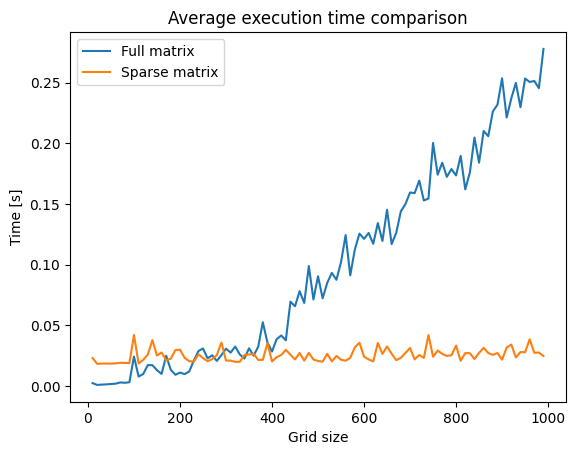

In [401]:
import timeit

# Implement the FD formula in full matrix form
def FD(a,b,n):
  h = (b-a) / n
  FD = np.zeros((n+1,n+1))

  for i in range(n):
    FD[i,i] = -1
    FD[i,i+1] = 1

  return FD / h

# Set up interval
a=0
b=1

# Fix function f using symbolic tool
t = sym.var('t')
fsym = 0.5 * t**2
# Define the function as an inline function
f = sym.lambdify(t, fsym )

# Allocate space for timings
time_full = []
time_sparse = []

# Compare execution times of the two methods for different grid sizes
for N in range(10,1000,10):
  h = (b-a) / N
  # set up grid points
  x = np.linspace(a,b,N+1)
  # Time the full matrix method solution (150 repetitions, to get a good average)
  time_full.append(timeit.timeit(lambda: FD(a,b,N).dot(f(x))[1:N], number=150))
  # Time the sparse matrix method solution (150 repetitions, to get a good average)
  time_sparse.append(timeit.timeit(lambda: (forw_diff(N)/h).dot(f(x))[1:N], number=150))
  
plt.plot(range(10,1000,10),time_full,label='Full matrix')
plt.plot(range(10,1000,10),time_sparse,label='Sparse matrix')
plt.legend()
plt.xlabel('Grid size')
plt.ylabel('Time [s]')
plt.title('Average execution time comparison')
plt.show()


# Finite Differences for two-points boundary value problems with constant coefficients

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approximate the second derivative.

Given $h>0$,

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [390]:
def CD2(N):
  # Function defining nominator of
  # second central FD formula on a
  # uniform grid in sparse CSR format
  data = [np.ones(N), -2*np.ones(N+1), np.ones(N)]
  return sp.diags(data,[-1,0,1], format="csr")


Example of second central matrix.

In [391]:
N=5
A = CD2(N)

#print(cent_diff)
print(A.todense())

[[-2.  1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1. -2.]]


Test problem:

$(a,b)=(0,\pi)$

u(x)=sin(x)

In [392]:
# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution
usym = sym.sin(t)
u = sym.lambdify(t, fsym )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

In [393]:
# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
F=-h**2*f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A = A[1:-1,1:-1]


Import solver

In [394]:
from scipy.sparse.linalg import spsolve

Solve problem and print result

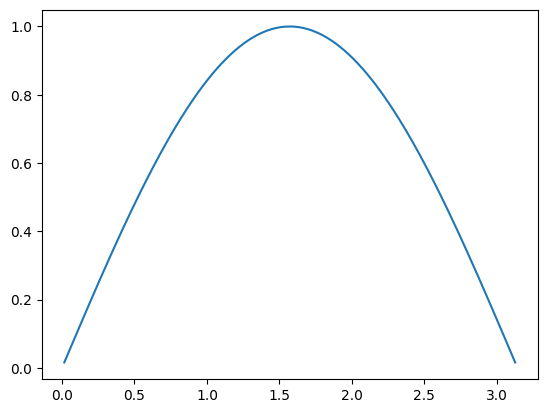

In [395]:
# Compute solution at internal nodes
uh = spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)

In [396]:
# print max error

print(np.max(np.abs(uh-u(x[1:-1]))))

2.0561929504392396e-05


**Exercise 2.** test for convergence and plot convergence plot

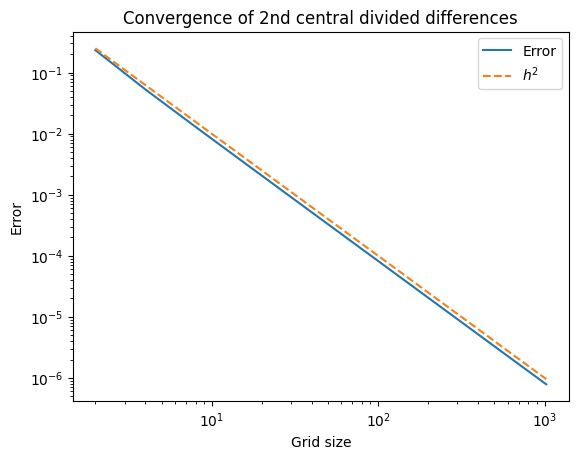

In [397]:
no_experiments = 10
error = np.zeros(no_experiments)
nn = np.zeros(no_experiments)

for i in range(no_experiments):
  n = 2**(i+1)
  nn[i] = n
  h = (b-a)/n
  x = np.linspace(a,b,n+1)
  A = CD2(n)
  F = -h**2*f(x[1:-1])
  A = A[1:-1,1:-1]
  uh = spsolve(A,F)
  error[i] = np.max(np.abs(uh-u(x[1:-1])))
  
plt.loglog(nn,error, label='Error')
plt.loglog(nn,nn**(-2), linestyle='--', label='$h^2$')
plt.title('Convergence of 2nd central divided differences')
plt.xlabel('Grid size')
plt.ylabel('Error')
plt.legend()
plt.show()

**Exercise 3.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

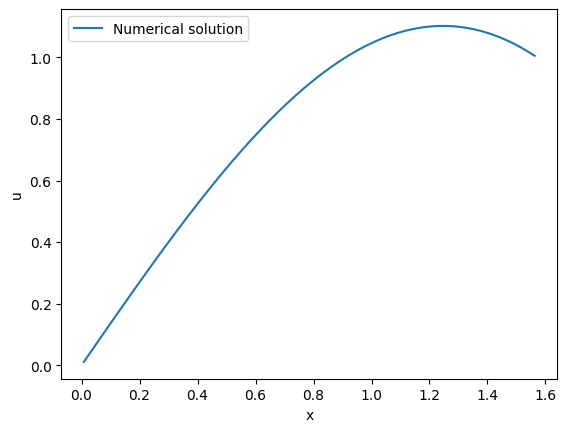

In [398]:
def CD2(N):
    # Function defining nominator of
    # second central FD formula on a
    # uniform grid in sparse CSR format
    data = [np.ones(N-1), -2*np.ones(N), np.ones(N-1)]
    return sp.diags(data,[-1,0,1], format="csr")

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution
usym = 2*sym.sin(t)-2*t/np.pi
u = sym.lambdify(t, usym )

# Problem domain
a=0
b=np.pi/2

# Alpha
alpha = 1/2

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N-1)

# Right-hand side
F=-h**2*f(x[1:-1])/alpha

# Non-homogeneous Dirichlet boundary conditions
u_a = np.sin(a) # Change this to impose different boundary conditions
u_b = np.sin(b) # Change this to impose different boundary conditions
F[0] -= u_a
F[-1] -= u_b

# Compute solution at internal nodes
uh = spsolve(A,F)

# Evaluate exact solution
u_exact = u(x)

# plot solution
plt.plot(x[1:-1],uh,label='Numerical solution')
#plt.plot(x,u_exact,label='Exact solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()


**Exercise 4.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

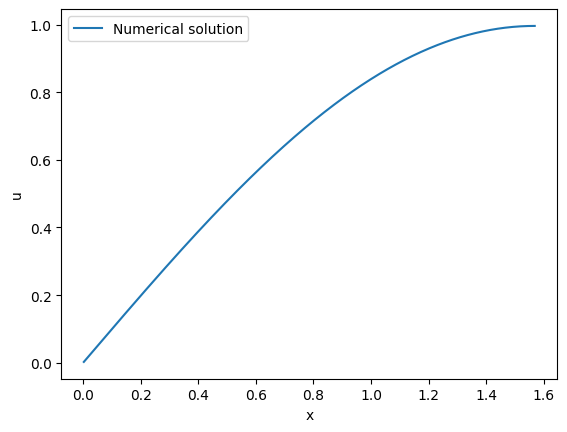

In [399]:
def CD2(N):
    # Function defining nominator of
    # second central FD formula on a
    # uniform grid in sparse CSR format
    data = [np.ones(N-1), -2*np.ones(N), np.ones(N-1)]
    return sp.diags(data,[-1,0,1], format="csr")

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution
usym = sym.sin(t)
u = sym.lambdify(t, usym )

# Problem domain
a=0
b=np.pi/2

# Size of grid
N=600
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N-1)

# Right-hand side
F=-h**2*f(x[1:-1])

# Boundary conditions: modify last row of matrix and right-hand side vector to impose homogeneus Neumann boundary conditions
# (and Dirichlet boundary conditions at the left end)
A[-1,-1] = -2
A[-1,-2] = 2
u_a = np.sin(a) # Change this to impose a different Dirichlet boundary condition
F[0] -= u_a

# Compute solution at internal nodes
uh = spsolve(A,F)

# Evaluate exact solution (for comparison)
u_exact = u(x)

# plot solution
plt.plot(x[1:-1],uh,label='Numerical solution')
#plt.plot(x,u_exact,label='Exact solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

**Exercise 5.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


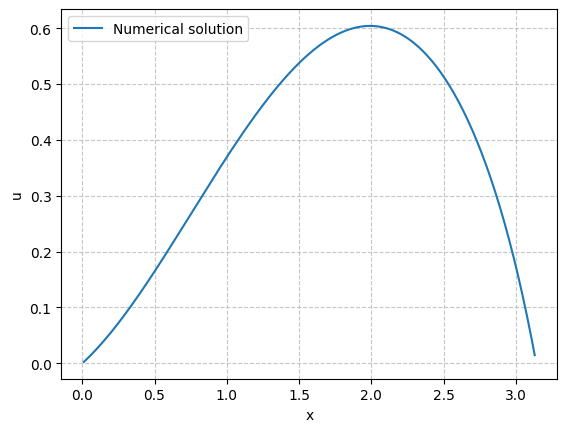

In [ ]:
def A(N):
    data = [np.ones(N-1), -2*np.ones(N), np.ones(N-1)]
    return sp.diags(data,[-1,0,1], format="csr")

def B(N):
    data = [-np.ones(N-1), np.ones(N-1)]
    return sp.diags(data,[-1,1], format="csr")

def C(N):
    data = [np.ones(N)]
    return sp.diags(data,[0], format="csr")

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Problem domain and parameters (modify as needed)
a=0
b=np.pi

# Size of grid
N=300
h=(b-a)/N

# Parameters of the problem (modify as needed)
alpha = 1/2
beta = 1
gamma = 1

# Grid
x=np.linspace(a,b,N+1)

# Complete matrix
L = (-alpha/h**2)*A(N-1) + (beta/(2*h))*B(N-1) + gamma*C(N-1)

# Right-hand side
F=f(x[1:-1])

# Non-homogeneous Dirichlet boundary conditions
u_a = np.sin(a) # Change this to the desired value
u_b = np.sin(b) # Change this to the desired value
F[0] += u_a*(alpha/h**2+beta/(2*h))
F[-1] += u_b*(alpha/h**2-beta/(2*h))

# Compute solution at internal nodes
uh = spsolve(L,F)

# Plot solution
plt.plot(x[1:-1],uh,label='Numerical solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()
    